(irmf-chapitre)=
# IRM fonctionnelle

<table>
  <tr>
    <td align="center">
      <a href="https://github.com/anproulx">
        <img src="https://avatars.githubusercontent.com/u/65092948?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Andréanne Proulx</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
        <a title="Révision du texte">👀</a>
    </td>
    <td align="center">
      <a href="https://github.com/danjgale">
        <img src="https://avatars.githubusercontent.com/u/14634382?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Dan J Gale</b></sub>
      </a>
      <br />
        <a title="Figure">🎨</a>
    </td>
    <td align="center">
      <a href="https://github.com/pbellec">
        <img src="https://avatars.githubusercontent.com/u/1670887?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Pierre bellec</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
        <a title="Révision du texte">👀</a>
    </td>
  </tr>
</table>

## Objectifs du cours

[L'imagerie par résonnance magnétique fonctionnelle](https://fr.wikipedia.org/wiki/Imagerie_par_r%C3%A9sonance_magn%C3%A9tique_fonctionnelle)
est une modalité d'imagerie qui permet de mesurer indirectement l'activité cérébrale. L'IRMf acquiert des images du cerveau en action en relation avec différentes conditions expérimentales, ayant été conçues pour isoler des processus cognitifs spécifiques. L'IRMf permet donc de cartographier l'organisation fonctionnelle du cerveau, dans différents contextes cognitifs.

```{figure} irm_fonctionnelle/irmf.jpg
---
width: 600px
name: irmf-ecran-fig
---
Les images d'IRMf permettent d'observer l'activation cérébrale, tiré de [wikipedia](https://fr.wikipedia.org/wiki/Imagerie_par_r%C3%A9sonance_magn%C3%A9tique_fonctionnelle#/media/Fichier:Researcher-test.jpg).
```
Les objectifs spécifiques du cours sont:
- Comprendre les principes **physiques** et **physiologiques** du signal IRMf.
- Comprendre le modèle de la **réponse hémodynamique**, invariante dans le temps, qui permet d'estimer le niveau d'activation en réponse à divers paradigmes expérimentaux.
- Connaître les principales étapes de **pré-traitement** des données IRMf, soit le **recalage**, le **lissage spatial** et le **filtrage de facteurs de non-intérêt**. Ces étapes sont nécessaires afin de réduire le bruit dans le signal IRMf, qui ne reflète pas l'activité neuronale.
- Connaître le principe de génération d'une **carte d'activation**, qui, à l'aide de modèles statistiques, permet de tester des hypothèses sur l'organisation fonctionnelle du cerveau.

## Principes physiques et physiologiques

### Images 3D+t

|               |   `IRM structurelle`     | `IRM fonctionnelle (T2*)`  |
| ------------- |:-------------:| -----:|
| `Objet d'étude`      | **Anatomie, structures et propriétés des tissus** | **Organisation fonctionnelle**|
| `Dimension`     | 1 volume - **3D**   |  Plusieurs volumes dans le temps - **4D** |
| `Durée de l'acquisition` | Plusieurs minutes |  Secondes |


Les images d'IRMf sont un peu comme un film du cerveau en action. Elles sont composées d'une **série de volumes 3D** qui se succèdent à une fréquence donnée, plutôt que d'un unique volume comme c'était le cas en IRM. Nous parlons alors d'images **4D**, ou bien **3D+t** puisqu'aux dimensions spatiales (`x`, `y`, `z`) s'ajoute la dimension du temps `t`. Nous pourrions, par exemple, acquérir 1 volume cérébral toutes les 2 secondes, pendant 6 minutes, ce qui résulterait en un jeu de données d'IRMf composé de 180 volumes 3D du cerveau.

/home/pbellec/.virtualenvs/psy3018/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


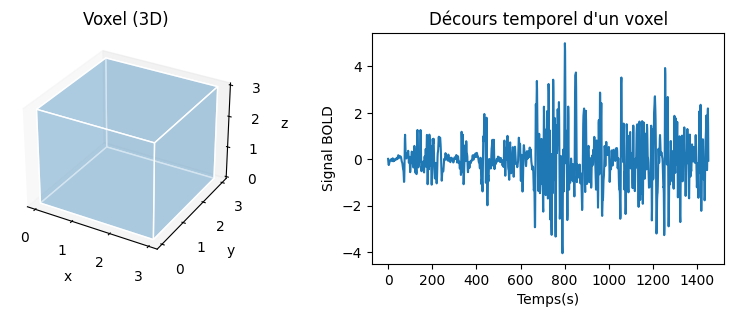

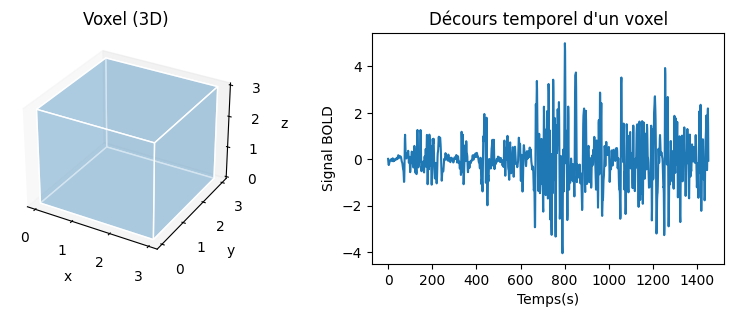

In [1]:
#importe les librairies nécessaires
import pandas as pd
import nilearn
import numpy as np
from nilearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Extraire les séries temporelles pour un sujet d'un jeu de données
haxby_dataset = datasets.fetch_haxby()
haxby_func_filename = haxby_dataset.func[0]

# initialiser le masque
brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

# appliquer le masque
brain_time_series = brain_masker.fit_transform(haxby_func_filename,
                                               confounds=None)
# fonctions de visualisations pour le voxel 3D
def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

# initialisation de la figure
fig = plt.figure(figsize=(10,3))

# visualiser le voxel
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.grid(False)
colors = np.array([[['#1f77b430']*1]*1]*1)
colors = explode(colors)
filled = explode(np.ones((1, 1, 1)))
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

x[1::2, :, :] += 1
y[:, 1::2, :] += 1
z[:, :, 1::2] += 1

ax1.voxels(x, y, z, filled, facecolors=colors, edgecolors='white', shade=False)
plt.title("Voxel (3D)")


# ajouter séries temporelles
# random voxel
voxel = 1
ax = fig.add_subplot(1, 2, 2)
ax.plot(brain_time_series[:, voxel])
ax.set_title("Décours temporel d'un voxel")

plt.xlabel("Temps(s)", fontsize = 10)
plt.ylabel("Signal BOLD", fontsize= 10)

from myst_nb import glue
glue("voxel-timeseries-fig", fig, display=False)

```{glue:figure} voxel-timeseries-fig
:figwidth: 800px
:name: "voxel-timeseries-fig"
Illustration d'un élément de volume (voxel), de taille 3 mm x 3 mm x 3 mm, et le décours temporel IRMf associé.
```

Le volume du cerveau (3D) est formé plusieurs milliers voxels, qui sont de petites unités de volumes (3D) ayant une coordonnée dans l'espace **x, y, z**. En IRMf, pour chaque voxel du cerveau, nous détenons plusieurs points de mesure de l'activité dans le temps, ce qui forme ce que l'on appelle une **série temporelle** ou **décours temporel**. Typiquement, quelques dizaines à centaines de points de mesures décrivent la série temporelle. Ces points de mesures sont séparés par un intervalle de temps, appelé `TR`, qui peut varier de millisecondes à secondes. Ces caractéristiques représentent un bon compromis entre résolution spatiale et temporelle. Comme nous le verrons plus loin, la série temporelle reflète de manière indirecte les changements d'activité neuronale dans le temps. Une grande partie du travail en IRM fonctionnelle consiste à analyser ces séries temporelles.

```{warning}
:name: tr-irmf-warning
Le paramètre `TR` en IRM fait référence au temps entre deux excitations radio-fréquences, qui est très court. En IRMf, le paramètre `TR` est la durée d'acquisition d'un volume entier, qui comprend de nombreuses excitations radio-fréquences.
```

```{admonition} Compromis entre résolution spatiale et temporelle en IRMf
:class: tip
:name: resolution

Lorsque l'on choisit une séquence d'IRMf, on est souvent amené à privilégier la résolution temporelle versus spatiale. On peut par exemple faire des images du cerveau entier en 700 ms avec une résolution spatiale de 3 x 3 x 3 mm$^3$, ou bien acquérir la même image avec une résolution spatiale de 2 x 2 x 2 mm$^3$, mais cette fois-ci en 1500 ms. Il n'y a pas un choix de paramètre meilleur qu'un autre, mais la chercheuse doit décider si la résolution spatiale ou temporelle est plus importante pour ses questions de recherche.
```
(couplage-neurovasculaire-irmf-section)=
### Couplage neurovasculaire

```{figure} irm_fonctionnelle/neurovascular-fig.jpg
---
width: 600px
name: neurovascular-fig
---
**Résumé de l'architecture neuro-gliale-vasculaire**. (a) Les astrocytes s'enveloppent autour des synapses, et ont des projections jusqu'à la surface des micro-capillaires. (b) Les astrocytes établissent des domaines anatomiques exclusifs, qui chevauchent de manière minimale ceux de leurs voisins astrocytes. (c) Schéma représentant la morphologie d'une cellule gliale, avec un corps connecté à une structure en arbre. (d) Micro-circuit neuronal. (e) microvascularisation cérébrale. (f) illustration de la taille des micro-circuits neuronaux et de la vascularisation. (g) pourcentage d'occupation du volume dans l'espace du circuit. Figure tirée de l'article par Zisis et coll. (2021) {cite:p}`Zisis2021-ai`, sous licence CC-BY-NC-ND.
```

Le lien entre activité neuronale et signal IRMf repose sur le phénomène du **couplage neurovasculaire**, et plus spécifiquement le couplage entre l'activité post-synaptique des neurones et les micro-capillaires sanguins. La production de neurotransmetteurs dans la fente synaptique entrainent une série de réactions chimiques dans les cellules gliales avoisinantes. Lorsque l'activité neuronale augmente, les réactions chimiques qui l'accompagnent entraînent une **demande métabolique** en nutriments et ultimement l'extraction d'oxygène dans les micro-capillaires de manière locale. Les événements suivants se produisent alors:
 * augmentation du volume des capillaires;
 * augmentation du flux sanguin;
 * augmentation l'acheminement en oxygène (oxyhémoglobine) vers les populations de neurones activés.

 L'augmentation d'extraction d'oxygène entraîne donc de manière paradoxale une augmentation locale de la concentration d'**oxyhémoglobine** (sang oxygéné) par rapport à la concentration en **désoxyhémoglobine** (sang désoxygéné) localement, ce qui est détectable au moyen de l'IRMf. Le premier modèle quantitatif du couplage neurovasculaire (dit “modèle du ballon”) a été proposé par Buxton et coll. (1998) {cite:p}`Buxton1998-jy`.


### Le signal BOLD
```{figure} ./irm_fonctionnelle/hemoglobine-fig.jpg
---
width: 600px
name: hemoglobine-fig
---
Illustration du transport de l'oxygène par l'hémoglobine dans le sang. Image par [ShadeDesign](https://www.shutterstock.com/g/ShadeDesign) disponible sur [shutterstock](https://www.shutterstock.com/image-illustration/vector-science-medical-icon-blood-hemoglobin-1472480087) ID `1472480087`, utilisée sous licence shutterstock standard.
```

Quelle est l'origine du **signal BOLD**? L'hémoglobine existe sous deux états, soit l'état oxygéné (porteur de l'oxygène) et désoxygéné (non-porteur d'oxygène). La présence de l'oxygène modifie les propriétés électromagnétiques de cette molécule:
- L'**oxyhémoglobine** est **diamagnétique**
- La **désoxyhémoglobine** est **paramagnétique**

Ce que cela veut dire, c'est que quand elles sont soumises à des impulsions électromagnétiques, ces deux molécules se comportent de manière très différente. La désoxyhémoglobine va créer des inhomogénéités du champ magnétique, alors que l'oxyhémoglobine n'a pas d'effet sur ce même champ. Les séquences IRM pondérées $T_2^*$ sont très sensibles à de telles inhomogénéités. La désoxyhémoglobine déforme donc le champ magnétique $B_O$ induit par l'aimant, ce qui fait en sorte que le temps de relaxation $T_2^*$ est plus rapide. Les images acquises en IRMf utilisent donc un contraste en $T_2^*$, et cela a pour effet d'amplifier le signal quand le sang devient plus oxygéné en réponse à une augmentation de l'activité neuronale. Pour cette raison, le signal utilisé en IRMf est appelé signal BOLD, pour _Blood oxygenation level-dependent_, soit signal dépendant de l'oxygénation du sang.

|               |   'Désoxyhémoglobine'     | `Oxyhémoglobine`  |
| ------------- |:-------------:| -----:|
|Propriétés électromagnétiques | Paramagnétique | Diamagnétique|
| Impact sur le signal BOLD      | **Réduit** le signal BOLD  | **Augmente** le signal BOLD|
| $T_2^*$    | Décroît plus **rapidement**   |   Décroît plus **lentement** |
| Effet sur le champ | **Ajout d'inhomogénéités/distorsions** |  **Pas d'inhomogénéités**  |


```{figure} ./irm_fonctionnelle/t2star.png
---
width: 600px
name: t2star-fig
---
Lorsqu'une molécule comme la désoxyhémoglobine est présente, les spins se déphasent plus rapidement. Il est possible de modifier la séquence d'IRM pour éliminer ce phénomène, et c'est ce que l'on fait pour obtenir une image pondérée en $T_2$ traditionnelle. Si l'on ne modifie pas la séquence, le paramètre de décroissance apparait plus court, et c'est ce que l'on appelle le $T_2^*$.
```

### Fonction de réponse hémodynamique

#### Réponse à une impulsion courte

/home/pbellec/.virtualenvs/psy3018/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


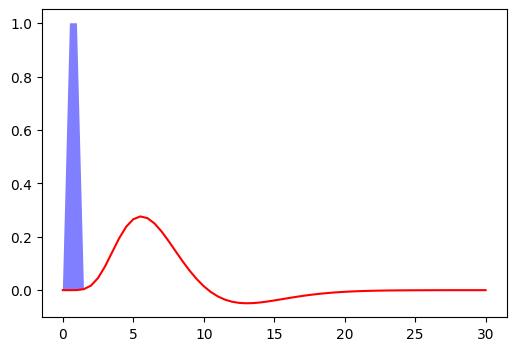

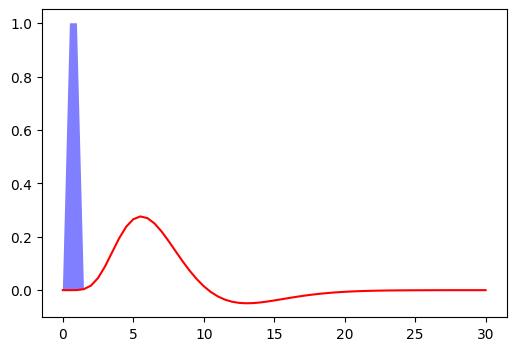

In [2]:
# To get an impulse response, we simulate a single event
# occurring at time t=0, with duration 1s.
import numpy as np
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude

# Now we plot the hrf
from nilearn.glm.first_level import compute_regressor
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))

# obtain the signal of interest by convolution
signal, name = compute_regressor(
    exp_condition, 'glover', frame_times, con_id='main',
    oversampling=16)

# plot this
plt.fill(frame_times, stim, 'b', alpha=.5, label='stimulus')
plt.plot(frame_times, signal.T[0], 'r', label=name[0])

# Glue the figure
from myst_nb import glue
glue("hrf-fig", fig, display=False)

```{glue:figure} hrf-fig
:figwidth: 800px
:name: "hrf-fig"
Réponse hémodynamique à une impulsion unitaire d'une durée de seconde, suivant le modèle proposé par Glover and coll. (1999) {cite:p}`Glover1999-cb`. Le code pour générer cette figure est adaptée d'un [tutoriel](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py) Nilearn, et la figure est sous licence CC-BY.
```
La figure qui suit montre la réponse hémodynamique attendue suite à une impulsion finie d'activation au temps 0, et de durée de 1 seconde. La réponse à ce type de stimulus permet de visualiser la réponse hémodynamique la plus largement utilisée, décrivant la relation maintenue entre l'activité neuronale (bleu) et le signal BOLD (rouge), en fonction du temps. L'axe `x` représente le temps, en secondes, et l'axe `y` le signal cérébral, exprimé en pourcentage du changement par rapport à une ligne de base. Les caractéristiques importantes de la fonction de réponse hémodynamique sont:

- **la résolution temporelle**: il s'agit d'une réponse lente, qui dure entre **15 à 20 secondes** suivant le stimulus
- **le temps avant l'atteinte de l'amplitude maximale**: de **4 à 6 secondes**
- **Creux post-stimulation (*Undershoot* en anglais)**: décroît à partir de l'amplitude maximale jusqu'à se retrouver sous la ligne de base.
- **Retour à la ligne de base**: La fonction retrouve le niveau précédant la stimulation après environ **15 à 20** secondes
- **Amplitude maximale**: L'ordre du changement relatif du signal BOLD atteint environ **5%** pour des stimulations d'ordre sensorielle, alors qu'elle est plutôt de **0,1 à 0,5%** pour d'autres paradigmes cognitifs

```{admonition} Attention!
:class: tip
:name: adéquation du modèle-tip

Le modèle de réponse hémodynamique ci-dessus est très rigide et peut s'avérer être une hypothèse invalide pour certaines populations, notamment si le couplage neurovasculaire est différent de l'étude originale de Glover and coll. (1999) {cite:p}`Glover1999-cb`. C'est probablement le cas, par exemple, chez les personnes âgées ou chez les individus ayant des maladies cardiovasculaires. La fonction de réponse hémodynamique peut également varier d'une région du cerveau à l'autre. Il est possible d'utiliser des modèles de la réponse hémodynamique qui sont plus flexibles et permettent, par exemple, de modifier le temps du pic de la réponse.
```

#### Le cerveau (BOLD) comme un système
```{figure} ./irm_fonctionnelle/systeme-fig.png
---
width: 400px
name: systeme-fig
---
Un système prend un décours temporel d'entrée et lui associe un décours temporel de sortie. Figure sous licence CC-BY.
```

Le processus qui transforme l'activité neuronale en un signal BOLD peut se formaliser dans le cadre général de la théorie des systèmes. Plus spécifiquement, la fonction de réponse hémodynamique de la {numref}`hrf-fig` est généralement approximée comme un système linéaire et invariant dans le temps. Cette approximation sous-tend les inférences que l'on fait sur l'organisation fonctionnelle du cerveau: nous l'employons dans le but d'estimer la réponse à une tâche ou condition donnée. La fonction de réponse hémodynamique de la {numref}`hrf-fig` se rapporte à un contexte expérimental simple: une stimulation courte et isolée. En réalité, les **paradigmes expérimentaux sont beaucoup plus complexes**: ils alternent à maintes reprises entre différentes conditions expérimentales/stimuli (par blocs, aléatoirement ou dans un ordre précis). De plus, ils comportent souvent plus d'une stimulation rapprochée dans le temps, ou/et des stimuli qui se prolongent sur plusieurs millisecondes ou secondes. Qu'advient-il alors de la fonction de réponse hémodynamique? Une propriété clé d'un système linéaire est d'être additif, c'est à dire que la réponse à une stimulation longue peut être décomposée comme la superposition de réponses à des stimulations plus courtes. Une autre hypothèse clé est l'**invariance dans le temps**, qui nous dit que la réponse du système ne va pas varier si on effectue la même stimulation courte à différents instants. Quand on **combine** l'hypothèse de linéarité avec l'invariance dans le temps, il est possible de prédire la réponse à n'importe quelle série de stimuli complexes à partir de la réponse à une unique stimulation courte, comme présentée en {numref}`hrf-fig`. L'étude de Logothetis et al. (2001) {cite:p}`Logothetis2001-lt` a été la première à démontrer chez le singe que cette hypothèse de linéarité et d'invariance semble être assez bien respectée, au moins dans le cortex visuel pour des stimuli visuels simples (contexte de l'étude).

```{admonition} Additivité
:class: tip
:name: additivité-tip
Un système est dit **additif** si la réponse à plusieurs impulsions correspond à la somme des réponses à ces impulsions prises indépendamment. Ce comportement est illustré ci-dessous.

```{figure} ./irm_fonctionnelle/systeme-additif-fig.png
---
width: 400px
name: systeme-additif-fig
---
Figure sous licence CC-BY.
```

## Prétraitement des données d'IRMf
Nous avons abordé dans les sections précédentes divers aspects de la modélisation de la réponse hémodynamique. Un autre point important en IRMf est la modélisation du bruit et des sources de variations qui peuvent être présentes dans les séries temporelles. Différents **facteurs confondants** et **artéfacts** (provenant du scanner IRM ou du sujet scanné lui-même) peuvent induire des fluctuations substantielles dans le signal BOLD mesuré, et venir confondre les inférences faites sur l'activité neuronale en réponse à des tâches:

- bruit cardiaque,
- artéfact lié au mouvement du sujet lors de l'acquisition,
- défaut dans l'antenne,
- inhomogénéités dans le champ magnétique, notamment aux intersections air-tissu,
- différences entre l'anatomie des sujets.

Différentes stratégies de modélisation peuvent être employées pour réduire l'influence des facteurs confondants et des artéfacts. Dans cette section, nous présentons un aperçu de trois grandes étapes de prétraitement en IRMf, qui, typiquement sont appliquées séquentiellement. On parle de _chaîne de traitements_, ou encore _pipeline_ ou _worflow_ en anglais.

### Recalage

Le recalage consiste à aligner une image à une image de référence. C'est une étape de prétraitement complétée avant les analyses statistiques de groupe, comme celles-ci présupposent qu'il y a une correspondance entre les voxels des images provenant de différents sujets. Nous avons déjà discuté du {ref}`recalage <registration-tip>` dans la section sur la [morphometrie](morphometrie). Nous allons voir que trois types de recalage sont utilisés en IRM fonctionnelle.

#### Recalage du mouvement
```{figure} ./irm_fonctionnelle/mouvement-fig.png
---
width: 500px
name: mouvement-fig
---
Illustration du processus de recalage du mouvement au cours d'un examen d'IRMf. Figure sous licence CC-BY.
```
Souvent, le sujet ne maintient pas exactement la même position de la tête dans le scanner tout au long des acquisitions, qui peuvent parfois durer plus d'une heure et/ou exiger des arrêts (par exemple à cause de baillements, fatigue musculaire, clignement des yeux, etc.). Ces mouvements ont des impacts non négligeables sur le signal BOLD. Ils peuvent entraîner des distorsions de l'intensité du signal de l'image. Ils impliquent que, d'une image à l'autre, un même voxel ne correspond pas nécessairement à la même structure cérébrale. Comme le cerveau d'un même individu ne change pas de forme ou de taille à travers les acquisitions, cette étape utilise un cas particulier de transformation affine, appelée transformation rigide, ne comportant que trois translations (selon `x`, `y` et `z`) et trois rotations (selon `x`, `y` et `z`). On utilise un volume de référence comme cible pour le recalage, par exemple le premier volume de la série, le dernier, ou bien la moyenne de tous les volumes. Différents paramètres de mouvement sont estimés pour chaque volume, et peuvent être représentés au cours du temps comme sur le graphique ci-dessus.

```{admonition} Mouvements excessifs
:class: tip
:name: motion-tip
Le niveau de mouvement varie en fonction de la population étudiée. Les enfants et les personnes âgés ont tendance à bouger davantage que les jeunes adultes. Certains chercheurs choisissent d'exclure les sujets ayant bougé au-delà d'un certain seuil.
```

#### Recalage BOLD avec $T_1$
Il est commun d'aligner l'image BOLD avec l'image anatomique $T_1$ du sujet. Pourquoi? L'image fonctionnelle détient une moins bonne résolution spatiale que l'image structurelle $T_1$: nous avons de plus courtes durées d'acquisition pour acquérir un même volume. Le contraste entre structures anatomiques est aussi bien meilleur en $T_1$. Il est donc utile de superposer les deux images pour localiser les activations BOLD. Cette transformation est estimée de manière rigide, comme le mouvement. Notez qu'il existe aussi des déformations non-rigides causées par les non-uniformités du champ, et qui peuvent être corrigées de manière additionnelle.


#### Recalage dans l'espace stéréotaxique
```{figure} ./irm_fonctionnelle/registration-macaque.gif
---
width: 500px
name: registration-macaque-fig
---
Illustration du processus de recalage d'un IRM T1 sur un espace stéréotaxique (ici chez le macaque). On démarre par une transformation affine (pour corriger la position de la tête et sa taille), puis non-linéaire (pour ajuster la position des sillons et des structures sous corticales). Figure sous licence CC-BY 4.0 contribuée par [Dan J Gale](https://github.com/danjgale).
```
Pour les comparaisons inter-individuelles ou les analyses statistiques de groupe, il doit y avoir une correspondance entre les voxels des images provenant de différents individus. Or, les cerveaux et les structures anatomiques peuvent avoir différentes tailles et formes d'individus en individus. Le recalage dans l'espace stéréotaxique, aussi parfois appelée _normalisation spatiale_, consiste à recaler l'image $T_1$ dans un espace standard cible défini par l'atlas choisi, rendant ainsi comparables les cerveaux de différents individus. Cette technique est identique à ce qui est fait pour les études de morphométrie. Le template MNI152 (Montreal Neurological Institute) est largement employé comme espace standard dans la communauté. Cette transformation combine transformation affine et transformation non-linéaire.

### Lissage spatiale

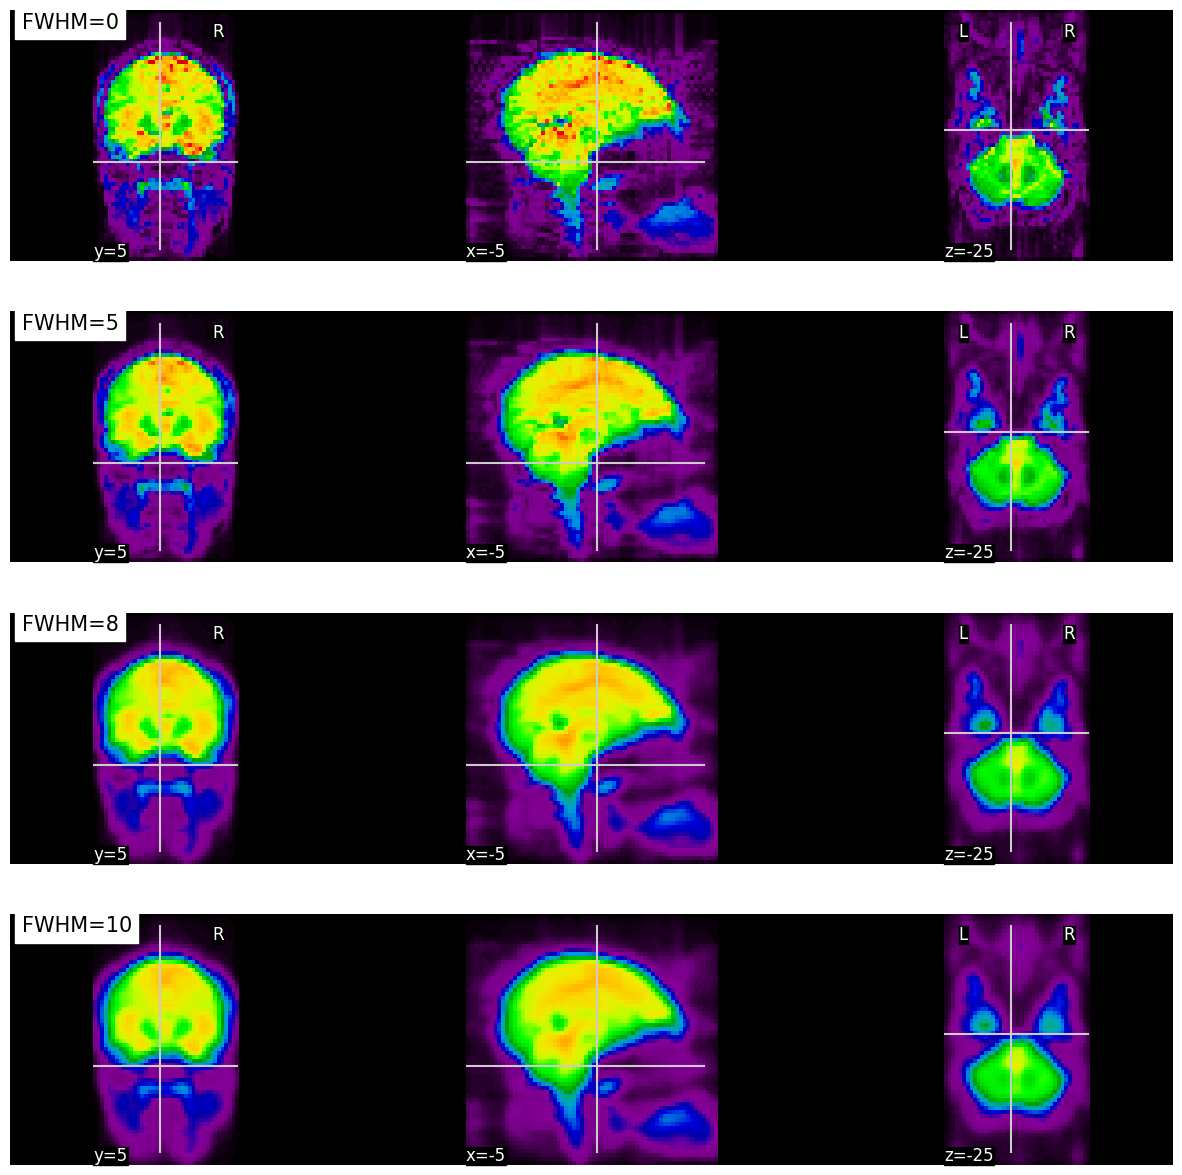

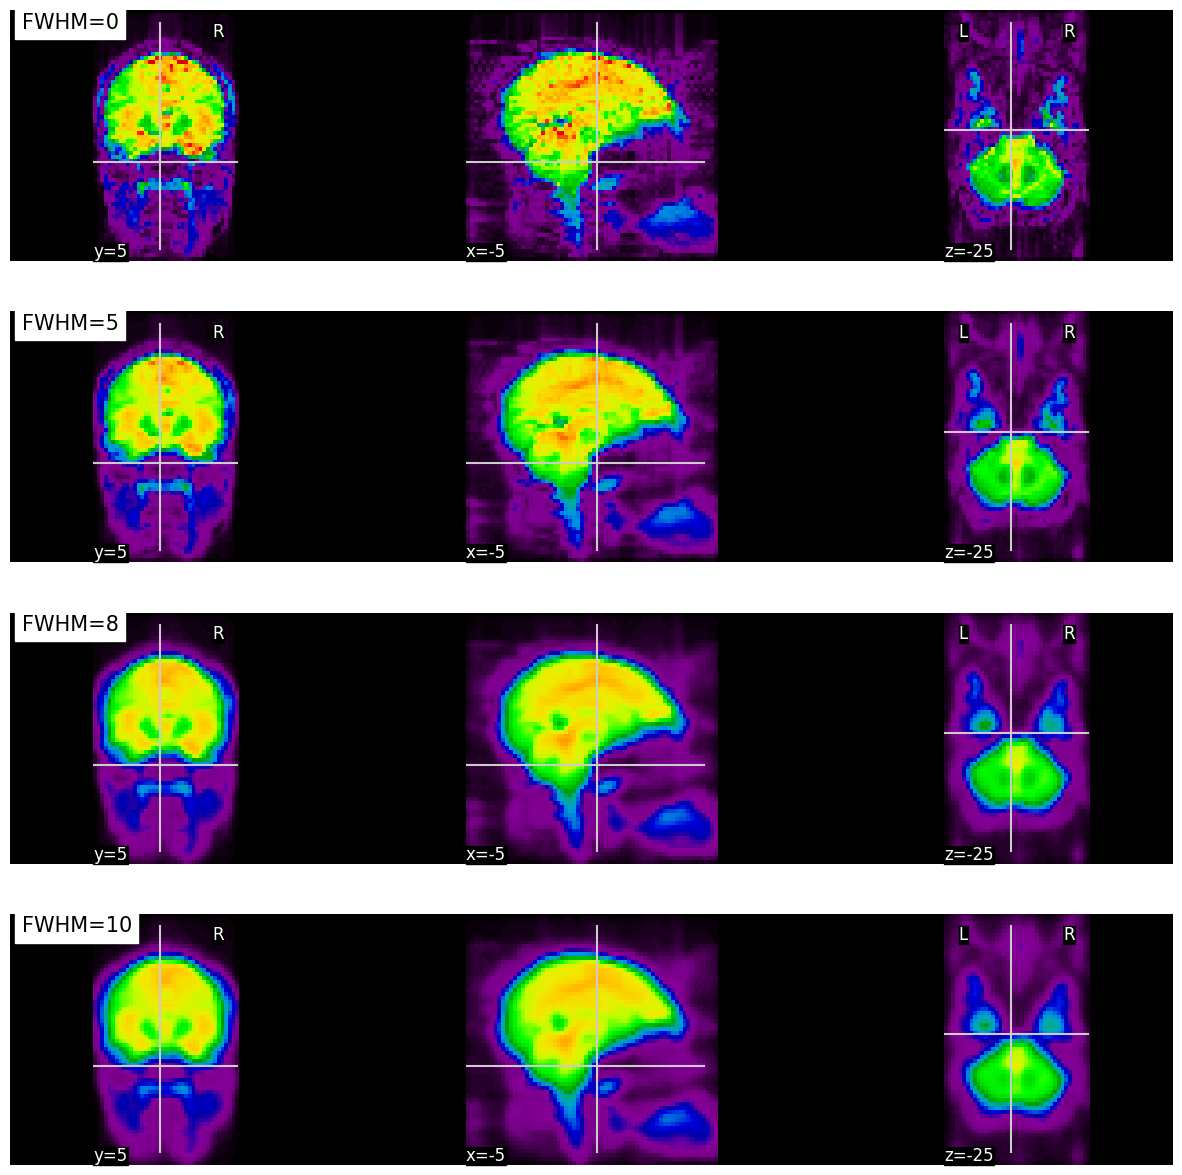

In [3]:
# Importe les librairies nécessaires
import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Télécharge un scan fonctionnel (Haxby)
from nilearn import datasets
haxby_dataset = datasets.fetch_haxby()

# calcule le volume moyen
from nilearn.image.image import mean_img
func_filename = haxby_dataset.func[0]
mean_haxby = mean_img(func_filename)

from nilearn.plotting import plot_epi, show

# Initialise la figure
fig = plt.figure(figsize=(15, 15))

from nilearn.plotting import plot_anat
from nilearn.image import math_img
from nilearn.input_data import NiftiMasker
from nilearn.image import smooth_img

list_fwhm = (0, 5, 8, 10)
n_fwhm = len(list_fwhm)
coords = [-5, 5, -25]

for num, fwhm in enumerate(list_fwhm):
    ax_plot = plt.subplot2grid((n_fwhm, 1), (num, 0), colspan=1)
    vol = smooth_img(mean_haxby, fwhm)
    plot_epi(vol,
              cut_coords=coords,
              axes=ax_plot,
              black_bg=True,
              title=f'FWHM={fwhm}',
              vmax=1500)

from myst_nb import glue
glue("smoothing-fmri-fig", fig, display=False)

```{glue:figure} smoothing-fmri-fig
:figwidth: 600px
:name: smoothing-fmri-fig
Illustration de l'impact du lissage sur un volume BOLD.
À mesure que le paramètre `FWHM` augmente, la mesure en un voxel représente la moyenne dans un voisinage spatial de plus en plus grand.
Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) à partir du jeu de données `haxby` (cliquer sur + pour voir le code). La figure est sous licence CC-BY.
```
Nous revenons ici sur une étape de prétraitement que nous avons déjà abordé lors du cours sur la VBM: le lissage spatial. Le processus du lissage est semblable pour l'IRM fonctionnelle, mais l'objectif de cette étape est un peu différent. Le bruit thermique aléatoire joue un plus grand rôle dans le signal BOLD, et peut avoir un effet néfaste sur les analyses statistiques. Le lissage spatial permet de diminuer ce bruit aléatoire. Mis à part l'amélioration du rapport signal sur bruit, le lissage permet également d'atténuer les imperfections de recalage entre sujets, en diffusant l'activité dans l'espace. De manière plus opérationnelle, le lissage consiste à prendre les voxels de l'image et à les remplacer par une nouvelle valeur considérant les valeurs des voxels voisins. Chaque voxel voisin se voit attribuer une pondération qui quantifie sa contribution à la nouvelle valeur attribuée à un voxel cible. La valeur originale du voxel cible est celle qui aura la plus grande pondération, et les valeurs des voxels voisins seront pondérés en fonction de la proximité entretenue avec le voxel cible. Donc, le lissage remplace la valeur associée à chaque voxel par une moyenne pondérée de ses voisins. Comme c'est une moyenne pondérée, la valeur originale du voxel est celle qui aura la plus grande pondération, mais les valeurs des voxels situés directement autour vont aussi l'affecter grandement. Le paramètre `FWHM` (*full width at half maximum*) contrôle l'échelle de ce lissage (plus important ou moins important). Il détermine l'étalement des voxels voisins qui participent à la nouvelle valeur d'un voxel cible. D'un point de vue mathématique, le paramètre `FWHM` représente la moitié de la largeur de la courbe gaussienne, qui décrit du bruit distribuée aléatoirement. Une plus grande valeur `FWHM` sous-tend une participation plus étalée des voxels voisins à la nouvelle valeur  d'un voxel cible de l'image. Plusieurs études choisissent `6 mm` comme valeur pour le paramètre `FWHM`.

### Filtrage des facteurs de non-intérêt

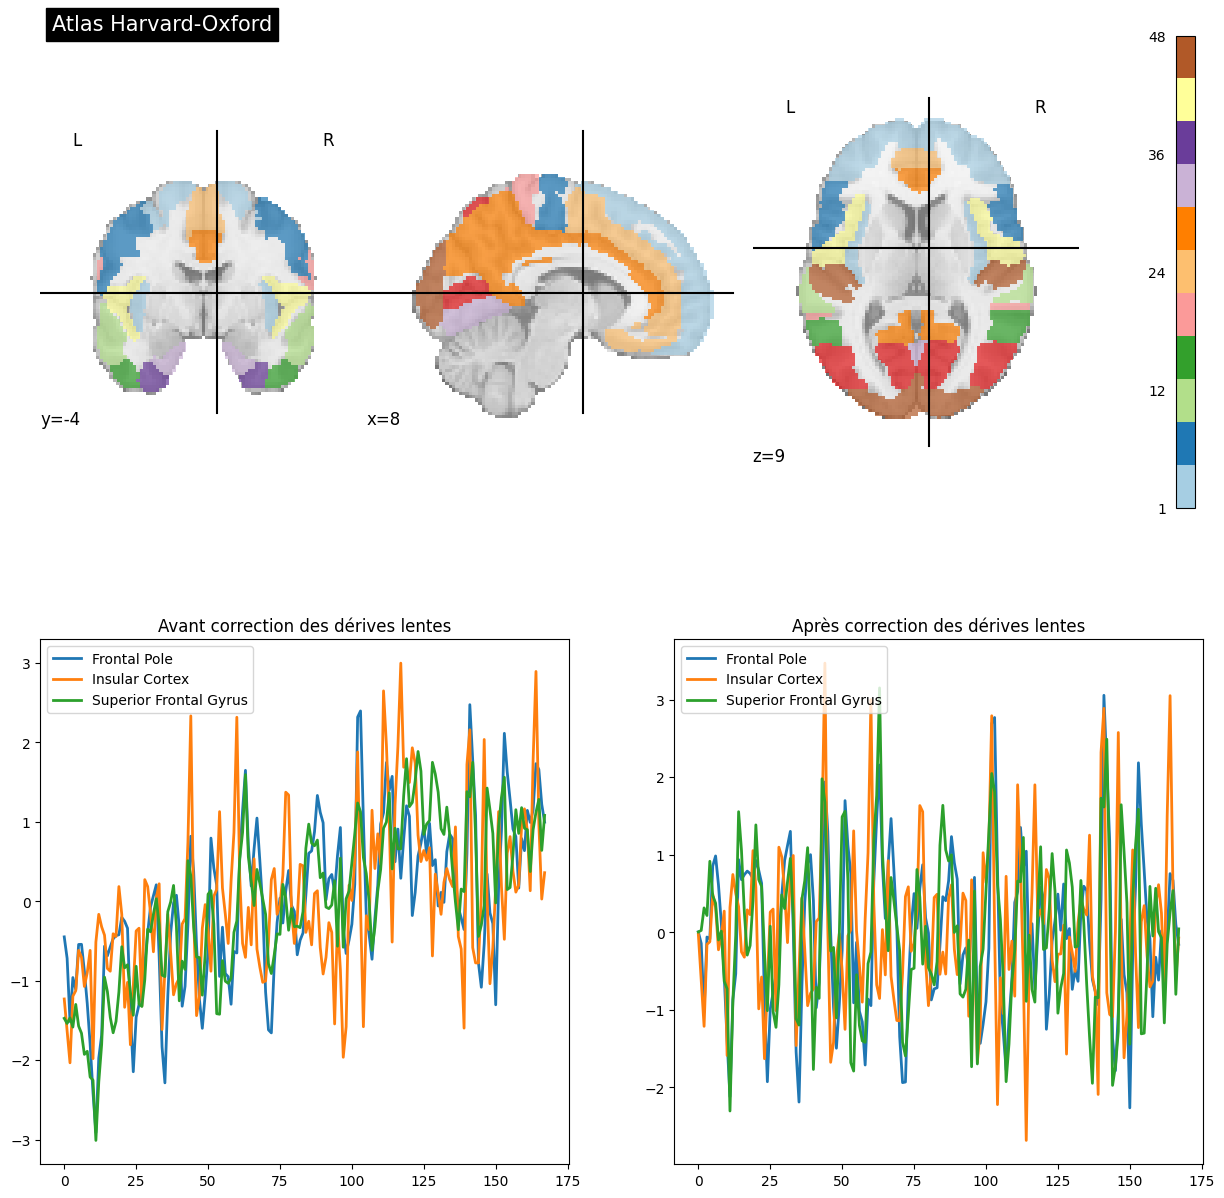

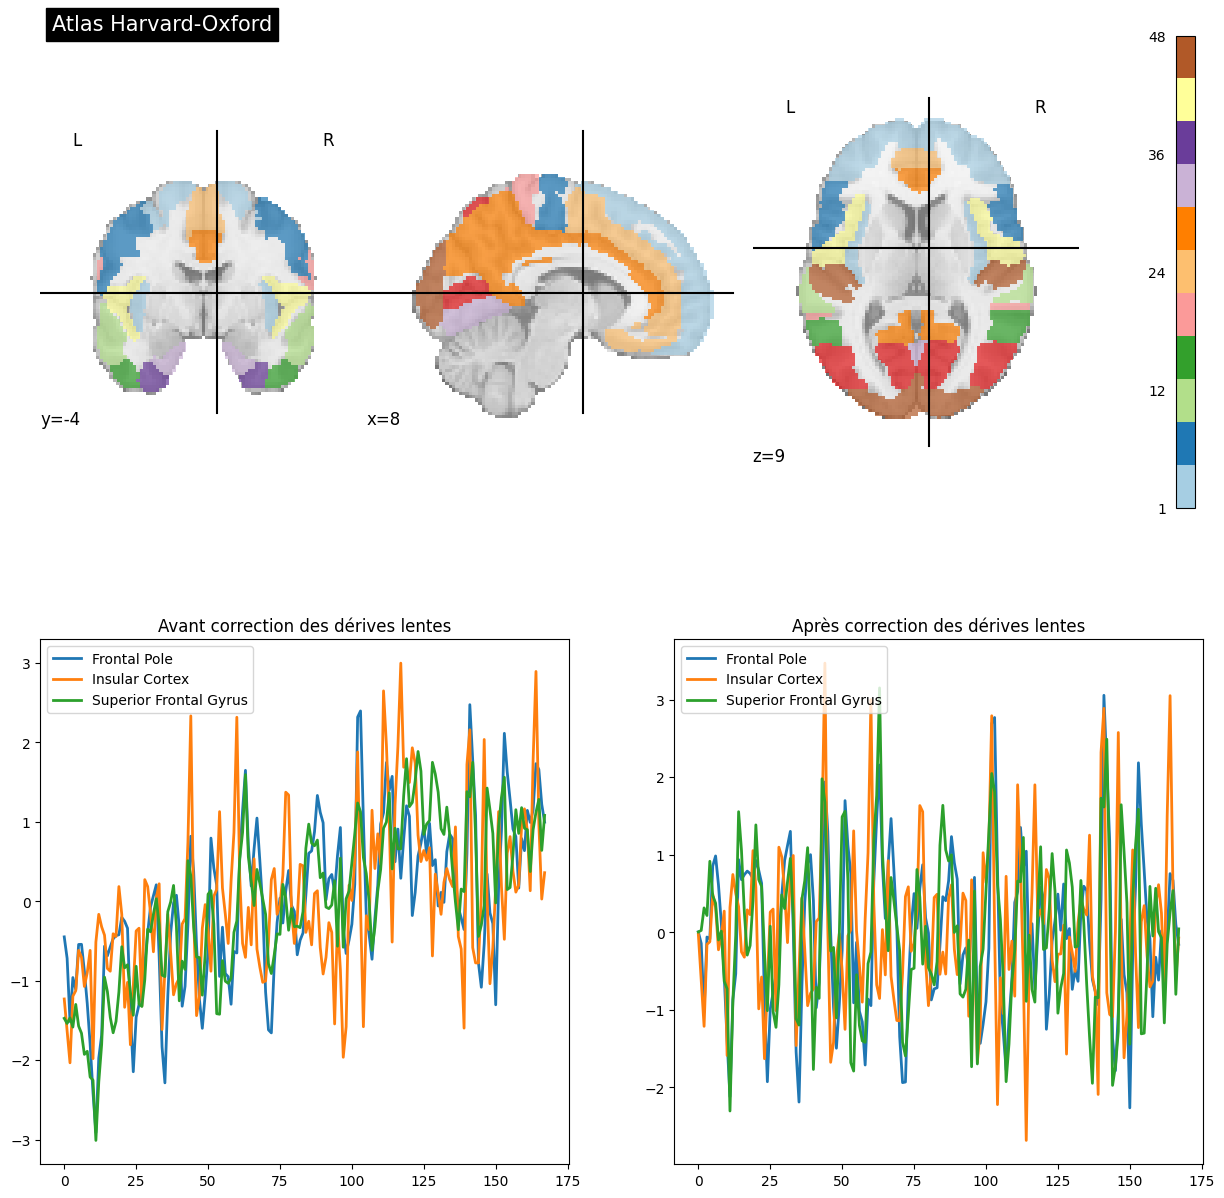

In [4]:
# Importe les librairies nécessaires
import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Importe un jeu de données fonctionnel (development_fmri)
from nilearn import datasets
dataset = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dataset.func[0]

# Importe un atlas (Harvard-Oxford)
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Initialise la figure
fig = plt.figure(figsize=(15, 15))

# Génère les séries temporelles
masker = NiftiLabelsMasker(atlas.maps,
                           labels=atlas.labels,
                           standardize=True)
masker.fit(func_filename)
signals = masker.transform(func_filename)

# Plot the atlas
from nilearn.plotting import plot_roi
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
plot_roi(atlas.maps,
    axes=ax,
    title="Atlas Harvard-Oxford",
    cut_coords=(8, -4, 9),
    colorbar=True,
    cmap='Paired')

# Plot les séries temporelles
import matplotlib.pyplot as plt
ax = plt.subplot2grid((2, 2), (1, 0), colspan=1)
for label_idx in range(3):
    ax.plot(signals[:, label_idx],
            linewidth=2,
            label=atlas.labels[label_idx + 1])  # 0 is background
ax.legend(loc=2)
ax.set_title("Avant correction des dérives lentes")

# Génère les séries temporelles après correction des dérives lentes
masker = NiftiLabelsMasker(atlas.maps,
                           high_pass=0.01,
                           t_r=4,
                           labels=atlas.labels,
                           standardize=True)
masker.fit(func_filename)
signals = masker.transform(func_filename)

# Plot les séries temporelles
ax = plt.subplot2grid((2, 2), (1, 1), colspan=1)
for label_idx in range(3):
    ax.plot(signals[:, label_idx],
            linewidth=2,
            label=atlas.labels[label_idx + 1])  # 0 is background
ax.legend(loc=2)
ax.set_title("Après correction des dérives lentes")

from myst_nb import glue
glue("detrending-fmri-fig", fig, display=False)

```{glue:figure} detrending-fmri-fig
:figwidth: 600px
:name: detrending-fmri-fig
On extrait les séries temporelles associées à l'atlas Harvard-Oxford avant (à gauche) et après (à droite) régression des dérives lentes.
Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/06_manipulating_images/plot_nifti_labels_simple.html#sphx-glr-auto-examples-06-manipulating-images-plot-nifti-labels-simple-py) à partir du jeu de données `development_fmri` (cliquer sur + pour voir le code). La figure est sous licence CC-BY.
```
La dernière étape de prétraitement qui sera abordée est celle du filtrage de facteurs de non-intérêt, ou facteurs confondants. Ces facteurs confondants peuvent avoir différentes sources, comme le bruit cardiaque, le bruit de respiration, ou le mouvement. Ils se caractérisent notamment par différentes fréquences du spectre, soit plus lentes ou rapides. Les dérives lentes constituent un exemple commun de facteurs de non-intérêt, et elles sont assez facilement repérables dans le signal. Dans ce cas, pouvons appliquer un filtre passe-haut, qui conserve uniquement les fréquences plus hautes qu'un certain seuil (par exemple 0.01 Hz). De nombreux autres types de facteurs confondants sont couramment régressés en IRMf - par exemple les paramètres de mouvement.

## Analyses statistiques

Les analyses statistiques comportent généralement des **analyses individuelles** dans lesquelles les séries temporelles sont analysées séparément pour chacun des sujets (on analyse l'effet des manipulations expérimentales), puis des **analyses de groupe** (on analyse l'effet de groupe), où ces données sont combinées pour plusieurs sujets pour être analysées. Dans cette section nous allons discuter brièvement de la génération de cartes statistiques individuelles. Nous reviendrons sur les analyses de groupe, et les modèles statistiques utilisées dans le chapitre sur les [cartes statistiques cérébrales](cartes_statistiques).

### IRMf - Expérience basée sur une tâche

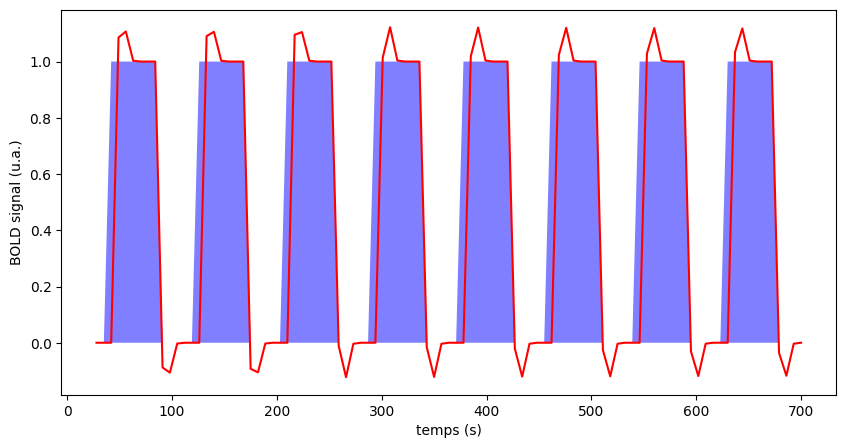

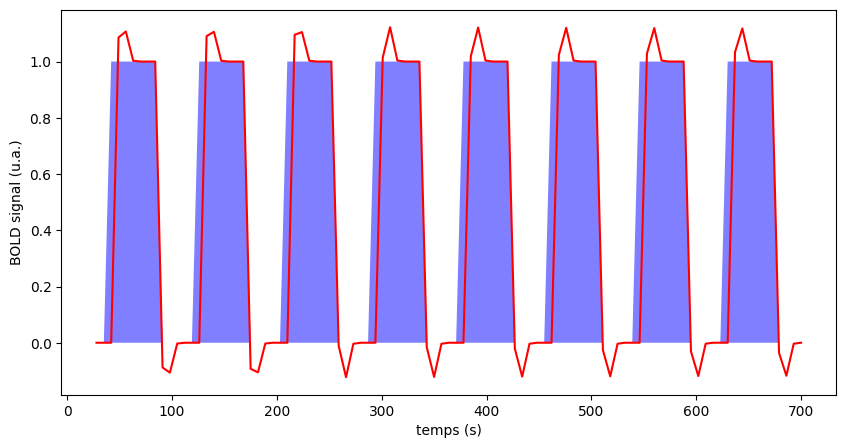

In [5]:
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load fMRI data
subject_data = fetch_spm_auditory()

fig = plt.figure(figsize=(10,5))

# load events
events = pd.read_table(subject_data['events'])
events['amplitude'] = 1
events = events[events['trial_type']=='active']
events = events.loc[:,['onset', 'duration', 'amplitude']].to_numpy().transpose()

frame_times = np.linspace(4*7, 100*7, 100-4+1)
from nilearn.glm.first_level import compute_regressor

block, name = compute_regressor(
        events, None, frame_times, con_id='main',
        oversampling=16)
block = block > 0

response, name = compute_regressor(
        events, 'glover', frame_times, con_id='main',
        oversampling=16)

plt.fill(frame_times, block, 'b', alpha=.5, label='stimulus')
plt.plot(frame_times, response, 'r', label=name)
plt.xlabel('temps (s)')
plt.ylabel('BOLD signal (u.a.)')

# Glue the figure
from myst_nb import glue
glue("hrf-auditory-fig", fig, display=False)

```{glue:figure} hrf-auditory-fig
:figwidth: 500px
:name: "hrf-auditory-fig"
Illustration d'un paradigme auditif en blocs. En bleu: périodes de stimulations audio. En rouge: réponse cérébrale prédite avec le modèle de réponse linéaire invariante dans le temps, et une réponse unitaire suivant le modèle de Glover et al. (1999) {cite:p}`Glover1999-cb`. Le code pour générer cette figure est adapté d'un [tutoriel](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py) Nilearn, et la figure est sous licence CC-BY.
```

Pour déterminer si l'activité des voxels du cerveau changent en réponse à des manipulations expérimentales, une approche expérimentale standard consiste à manipuler la tâche que réalise le sujet dans le scanneur, par exemple en alternant différentes conditions par blocs (stimulations audio, silence). Nous avons ensuite recours à des contrastes, aussi appelés analyses de soustraction qui procèdent en comparant les séries temporelles d'une condition à une autre condition, ou à un seuil de base. De manière simplifiée, l'analyse consiste à faire la différence de moyenne entre la période de silence et la période de stimulations auditives. Ces contrastes sont répétés pour chacun des voxels du cerveau, et génère une **carte statistique cérébrale**.

### Régression univariée massive
Il est possible de généraliser l'analyse de soustraction pour tenir compte de **1) la forme de la réponse hémodynamique**
**2) la présence de plusieurs conditions dans une même expérience**. En pratique, en faisant une hypothèse de système linéaire et invariant dans le temps, on génère une prédiction de la forme de la réponse à une condition expérimentale, comme dans la {numref}`hrf-auditory-fig`. Un modèle de régression linéaire est alors utilisé pour estimer l'amplitude de cette réponse, afin d'ajuster le modèle au plus près des valeurs mesurées dans un voxel. Cette régression génère un paramètre d'amplitude (et un test de significativité) pour chaque voxel. On parle de régression univariée, car chaque voxel du cerveau est analysé indépendamment. Et on parle de régression univariée massive, car on répète cette procédure pour des dizaines (ou même des centaines) de milliers de voxels!

(activation-section)=
### IRMf - Cartes d'activation

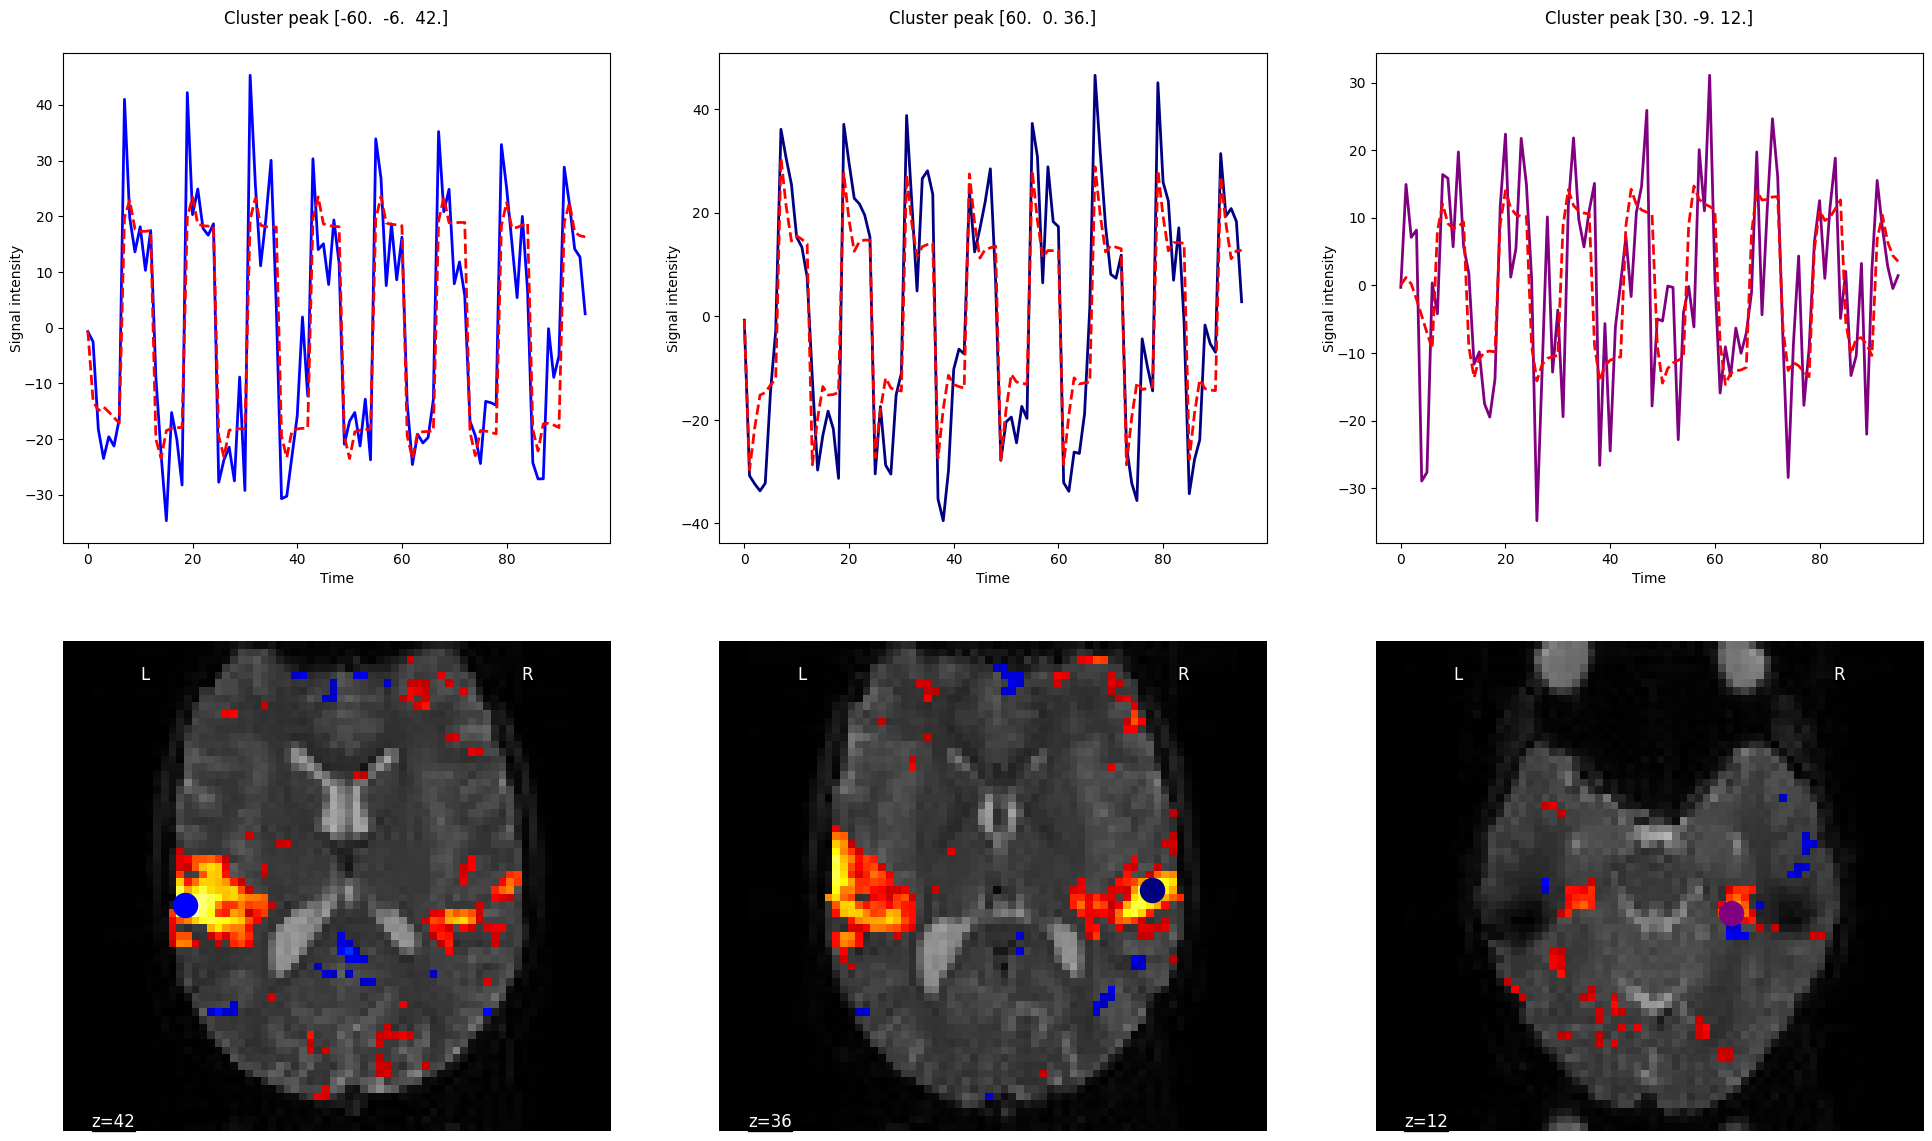

<Figure size 700x500 with 0 Axes>

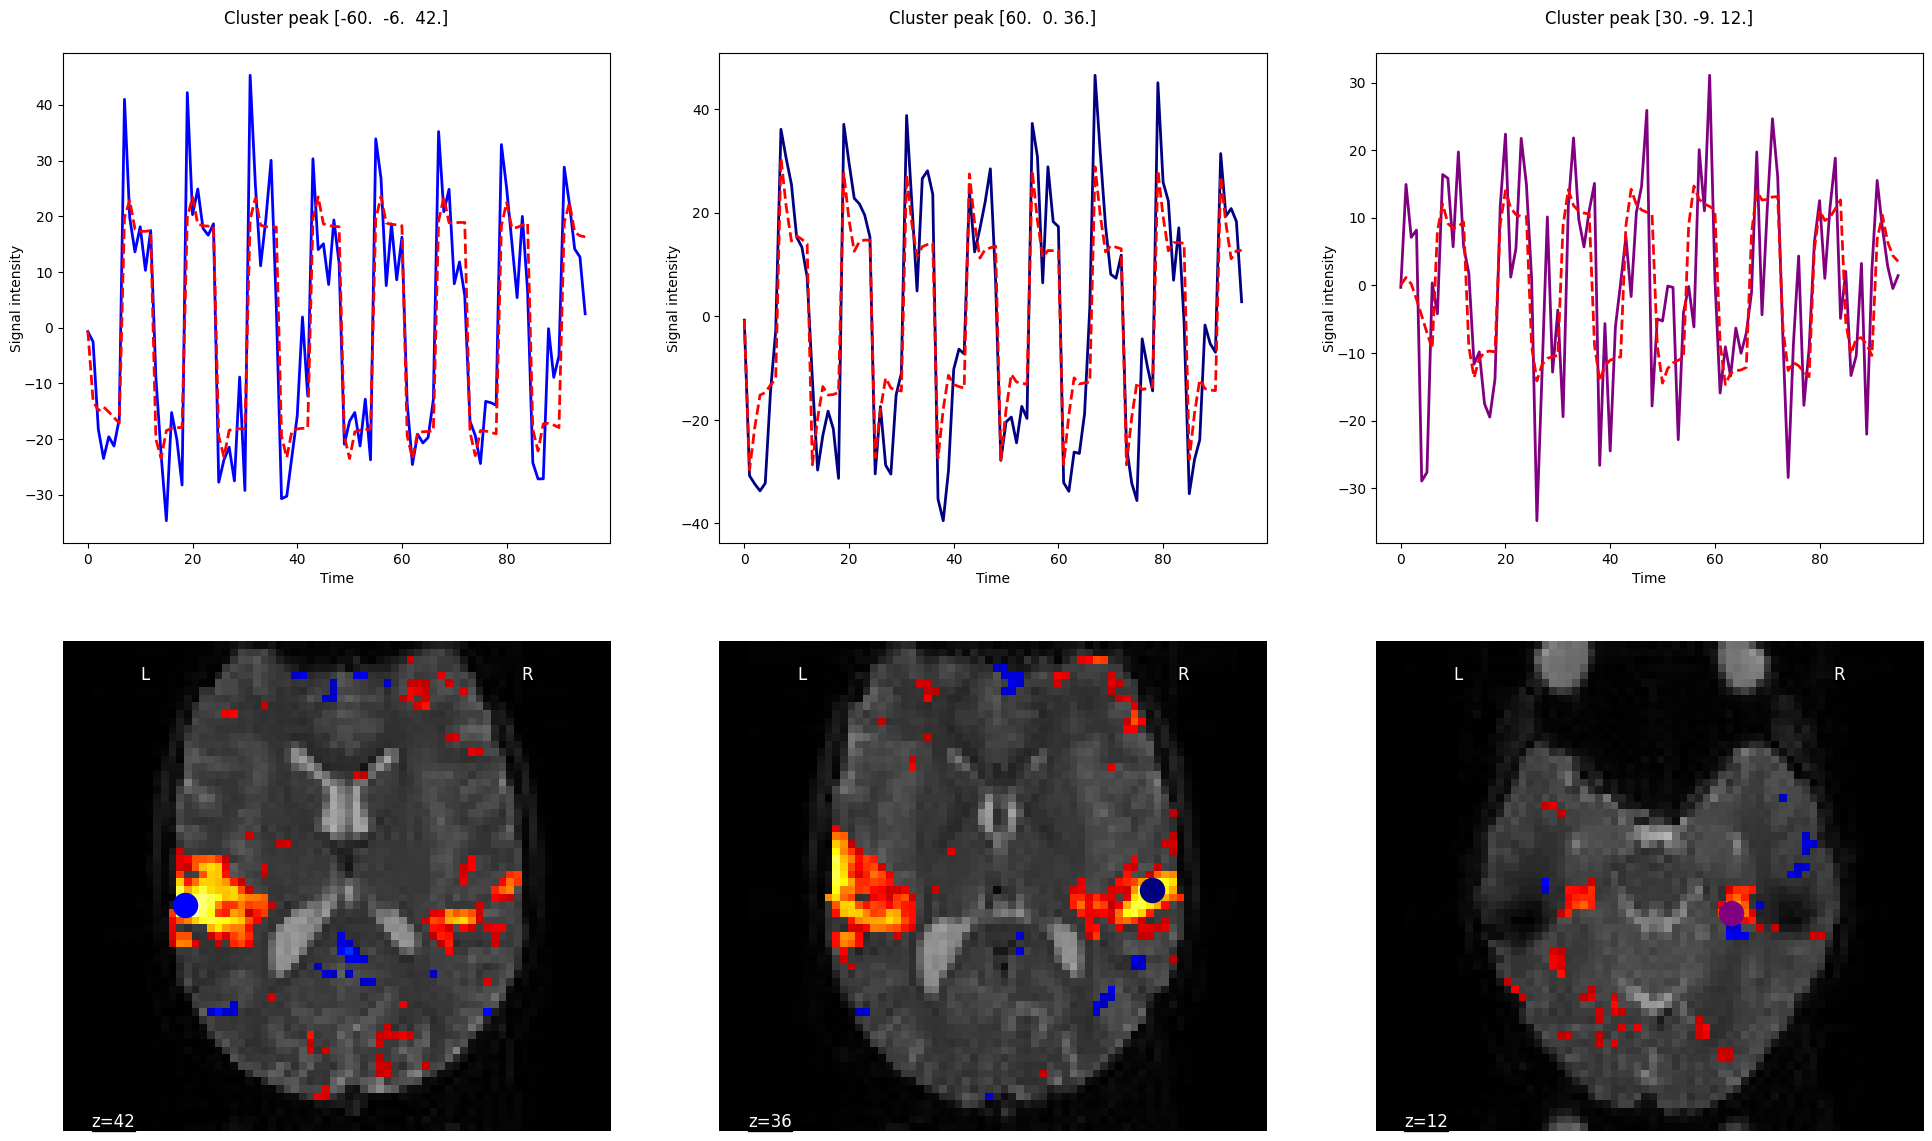

In [6]:
# Importe les librairies
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
import pandas as pd

# initialisation de la figure
fig = plt.figure(figsize=(7,5))

# load fMRI data
subject_data = fetch_spm_auditory()
fmri_img = image.concat_imgs(subject_data.func)

# Make an average
mean_img = image.mean_img(fmri_img)
mask = masking.compute_epi_mask(mean_img)

# Clean and smooth data
fmri_img = image.clean_img(fmri_img, high_pass=0.01, t_r=7, standardize=False)
fmri_img = image.smooth_img(fmri_img, 5.)

# load events
events = pd.read_table(subject_data['events'])

# Fit model
from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel(t_r=7,
                           drift_model='cosine',
                           signal_scaling=False,
                           mask_img=mask,                           
                           minimize_memory=False)

fmri_glm = fmri_glm.fit(fmri_img, events)

# Extract activation clusters
from nilearn.reporting import get_clusters_table
from nilearn import input_data
z_map = fmri_glm.compute_contrast('active - rest')
table = get_clusters_table(z_map, stat_threshold=3.1,
                           cluster_threshold=20).set_index('Cluster ID', drop=True)

# get the 3 largest clusters' max x, y, and z coordinates
coords = table.loc[range(1, 4), ['X', 'Y', 'Z']].values

# extract time series from each coordinate
masker = input_data.NiftiSpheresMasker(coords)
real_timeseries = masker.fit_transform(fmri_img)
predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

# Plot figure
# colors for each of the clusters
colors = ['blue', 'navy', 'purple', 'magenta', 'olive', 'teal']
# plot the time series and corresponding locations
from nilearn import plotting
fig1, axs1 = plt.subplots(2, 3)
for i in range(0, 3):
    # plotting time series
    axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
    axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c='r', ls='--', lw=2)
    axs1[0, i].set_xlabel('Time')
    axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        z_map, cut_coords=[coords[i][2]], threshold=3.1, figure=fig1,
        axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean_img)
    roi_img.add_markers([coords[i]], colors[i], 300)

fig1.set_size_inches(24, 14)

# Glue the figure
from myst_nb import glue
glue("auditory-fig", fig1, display=False)

```{glue:figure} auditory-fig
:figwidth: 800px
:name: "auditory-fig"
Carte d'activation pour un paradigme en blocs auditifs. Les trois principaux pics d'activation ont été identifiés, et le signal est présenté pour chaque pic, superposé avec l'activité prédite par le modèle basé sur les stimuli auditifs. Notez comme la forme de la réponse est identique pour les trois voxels sélectionnés, mais que l'amplitude du modèle varie (elle est estimée par la régression). Le code pour générer cette figure est adapté d'un [tutoriel](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py) Nilearn, et la figure est sous licence CC-BY.
```

Les cartes d'activation sont souvent ce que l'on retrouve dans des articles scientifiques dans la section des résultats. Ce sont des cartes du cerveau sur lesquelles se superposent les statistiques obtenues (par exemple niveau d'activation, test-t, valeur p). Elles sont superposées vis-à-vis des voxels ou régions correspondant(e)s. Elles sont souvent présentées suite à l'application de seuils ou de masques, venant isoler les régions les plus actives, avec les différences moyennes entre conditions les plus importantes et/ou les plus statistiquement significatives. Via de telles cartes, nous pouvons étudier l’organisation de systèmes d'intérêt (visuel, moteur, auditif, mémoire de travail, etc), mais aussi comparer des groupes ou bien associer le niveau d’activation à des traits d'intérêt comme le QI.

## Conclusions
La réalisation d'une expérience d'IRMf nécessite de bien penser les conditions d'intérêt et de contrôles pour isoler des processus cognitifs pertinents, mais cela requiert aussi de réfléchir aux hypothèses sous-jacentes:
 * **hypothèses neuronales**: les populations de neurones vont s'activer en réponse à nos conditions.
 * **hypothèses neurovasculaires**: Nous supposons que la réponse neuronale sera couplée à une réponse vasculaire caractéristique qu'il est possible de modéliser avec la fonction hémodynamique, laquelle est linéaire et invariante dans le temps.
 * **hypothèses statistiques**: Nous supposons que notre modèle de régression capture adéquatement l'activité cérébrale, et que nous tenons compte correctement des facteurs confondants et des artéfacts.

 Pour toutes ces raisons, il existe toujours des limitations importantes à l'interprétation que l'on peut faire de résultats en IRMf. Mais c'est aussi la technique cerveau entier non-invasive qui dispose de la meilleure résolution spatiale à ce jour.

## Références
```{bibliography}
:filter: docname in docnames
```

## Exercices

```{admonition} Exercice 1
:class: note
Vrai / faux?
 1. La réponse hémodynamique est faible une seconde après l’excitation neuronale.
 2. La réponse hémodynamique est maximale 2 secondes après l’excitation neuronale.
 3. La réponse hémodynamique est toujours visible 7 secondes après l’excitation neuronale.
 4. La réponse hémodynamique est toujours visible 30 secondes après l’excitation neuronale.
```

```{admonition} Exercice 2
:class: note
Vrai / faux?
 1. Les données en IRM fonctionnelle et structurelle doivent être alignées pour générer une carte d’activation.
 2. Le filtrage des facteurs de non-intérêt est important pour générer une carte d’activation.
 3. Le lissage spatial est utile, même pour une analyse individuelle.
```

```{admonition} Exercice 3
:class: note
Qu’est ce que le signal BOLD? (vrai / faux).
 1. Une séquence d’IRM pondérée en T2*.
 2. Un type de séquence d’IRM qui mesure directement l’activité des neurones.
 3. Un type de séquence d’IRM qui mesure l’oxygénation du sang.
```

```{admonition} Exercice 4
:class: note
Vrai / faux. Le principe d’additivité de la réponse hémodynamique est...
 1. Un modèle mathématique.
 2. Une propriété de base du couplage neurovasculaire, toujours vérifiée.
 3. Une hypothèse courante, en partie confirmée expérimentalement.
```

```{admonition} Exercice 5
:class: note
Choisissez la bonne réponse. Des données d’IRMf sont en général...
 1. Une image du cerveau.
 2. Une dizaine d’images du cerveau.
 3. Des dizaines d’images du cerveau, ou plus.
```

```{admonition} Exercice 6
:class: note
Quelle molécule dans le sang provoque un changement de signal mesuré par le BOLD? Pourquoi est-ce que l’IRM y est sensible?
```

```{admonition} Exercice 7
:class: note
Dans quelle portion de l’arbre vasculaire observe-t-on les changements principaux liés à l’activité neuronale locale?
```

```{admonition} Exercice 8
:class: note
On compare l’activation pour une tâche de mémoire dans le cerveau entre deux groupes de participants: des sujets sains et des sujets âgés (N=200 par groupe). Notre hypothèse est que la différence d’activité sera la plus forte dans le cortex frontal. En réalité, on trouve des différences en périphérie du cerveau, ce qui suggère des artefacts de mouvement.Suggérer deux modifications au protocole (recueil des données ou technique d’analyse) qui permettrait d’éviter ce phénomène.
```

```{admonition} Exercice 9
:class: note
Pour répondre aux questions de cet exercice, lisez d'abord l'article *High-resolution functional MRI of the human amygdala at 7 T* de Mensen et collaborateurs (publié en 2013 dans la revue *European Journal of radiology*, volume 82, pages 728 à 733).
Celui-ci est disponible en libre accès à cette [adresse](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3629563/).
Les questions suivantes requièrent des réponses à développement court.
 1. Quelle technique de neuroimagerie est utilisée? S'agit-il d'une technique structurelle ou fonctionnelle?
 2. Quelle est la force de l’IRM?
 3. Quel type de séquence d'acquisition d'image est utilisé? Listez les paramètres: TE et taille du champ de vue (en mm), durée de l’acquisition.
 4. Quel type de tâche est utilisé?
 5. Quelles étapes de prétraitements ont été appliquées?
```